In [1]:
from time import time
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from functions import RANSAC_VP
from functions import convert_homogenous_line
from functions import Angle_btw_vect
from scipy.interpolate import BSpline
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

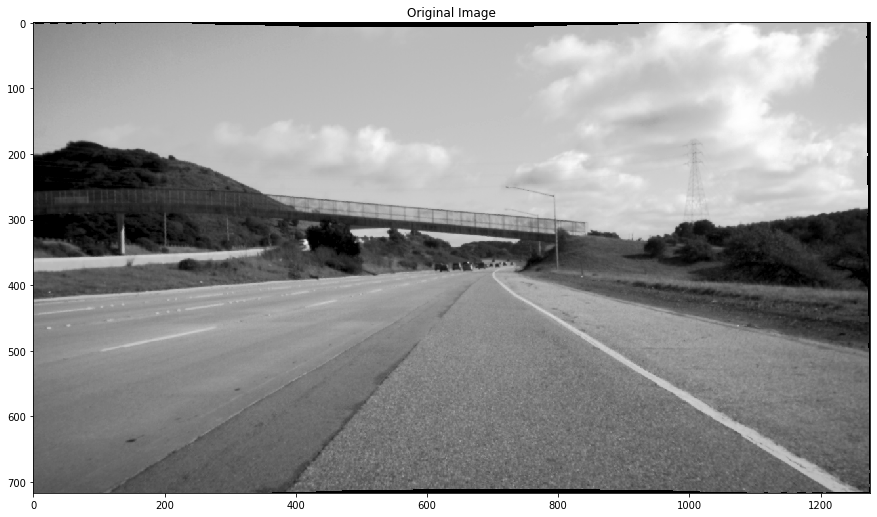

In [2]:
img = io.imread('example_image5.png', as_gray=True) # shape = (717,1276)
plt.imshow(img)
plt.title('Original Image')
plt.show()
img_pruned = img[10:710,:1270] # shape = (700,1270)

In [3]:
img_edge = cv.Canny(img_pruned,70,100, None,3) #edge by canny 
img_dsp =cv.cvtColor(img_edge,cv.COLOR_GRAY2BGR) #for display only
lines_Temp = cv.HoughLinesP(img_edge, 2, np.pi / 180, 40, None, 50, 10)
lines=[]
VPs=[]


for i in range(len(lines_Temp)):
    if abs((lines_Temp[i][0][3]-lines_Temp[i][0][1])/(lines_Temp[i][0][2]-lines_Temp[i][0][0]))<0.05:
        continue
    l = lines_Temp[i][0]
    cv.line(img_dsp, (l[0], l[1]), (l[2], l[3]), (0,0,255),1, cv.LINE_AA)
    lines.append([l])
    
lines=np.array(lines)
VP=RANSAC_VP(lines)
VPs.append(VP)

cv.circle(img_dsp, (round(VP[0]),round(VP[1])), 3, (0,255,0), 5 )
cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", img_dsp)

cv.waitKey()

horizon_height=VP[1]

layer= np.array([round((img_edge.shape[0]-horizon_height)*11/16+horizon_height),round((img_edge.shape[0]-horizon_height)*(7/16)+horizon_height), round((img_edge.shape[0]-horizon_height)*(3/16)+horizon_height),round(horizon_height)])
img_dsp =cv.cvtColor(img_edge,cv.COLOR_GRAY2BGR) #reinitiate display

for j in range( np.shape(layer)[0]):
    if(j!= 0):
        curr_img=img_edge[layer[j]:layer[j-1],:]
    else:
        curr_img=img_edge[layer[j]:,:]
    lines_Temp = cv.HoughLinesP(curr_img, 2, np.pi / 180, 40, None, 50, 10)
    lines=[]
    
    cv.line(img_dsp, ( 0,layer[j]), (    img_edge.shape[1],layer[j]   ), (100,100,100),3, cv.LINE_AA)
    
    for i in range(len(lines_Temp)):
        if abs((lines_Temp[i][0][3]-lines_Temp[i][0][1])/(lines_Temp[i][0][2]-lines_Temp[i][0][0]))<0.05:
            continue
        l = lines_Temp[i][0]
        #print('l')
        #print(l)
        #print('layer')
        #print(layer[i])
        cv.line(img_dsp, (l[0], l[1]+layer[j]), (l[2], l[3]+layer[j]), (0,0,255),1, cv.LINE_AA)
        lines.append([l])

    lines=np.array(lines)
    VP=RANSAC_VP(lines)
    VP[1]+=+layer[j]
    VPs.append(VP)
    cv.circle(img_dsp, (round(VP[0]),round(VP[1])), 3, (0,255,0), 5 )
    cv.imshow("figure", img_dsp)
    cv.waitKey()
   
VPs=np.array(VPs)




C:\Users\Kaixinc\AppData\Local\Temp/ipykernel_15668/3690642999.py:13: RuntimeWarning: divide by zero encountered in int_scalars
  if abs((lines_Temp[i][0][3]-lines_Temp[i][0][1])/(lines_Temp[i][0][2]-lines_Temp[i][0][0]))<0.05:


In [4]:



Temp_Nodes=[]
lower_bound=[round(img_edge.shape[1]/2), img_edge.shape[0]]
Temp_Nodes.append(lower_bound)
cv.circle(img_dsp, (lower_bound[0],lower_bound[1]), 3, (255,0,0), 5 )
cv.imshow("figure", img_dsp)
cv.waitKey()

for i in  range( np.shape(layer)[0]):
    line1=[0 , 1, -layer[i]]
    cv.line(img_dsp, (round(lower_bound[0]),round( lower_bound[1])), (    round(VPs[i,0]),round(VPs[i,1])   ), (100,100,100),1, cv.LINE_AA)
    line2=[lower_bound[0], lower_bound[1], VPs[i,0],VPs[i,1] ]
    line2 = convert_homogenous_line(line2)
    lower_bound= np.cross(line1, line2)
    lower_bound/=lower_bound[-1]
    Temp_Nodes.append(lower_bound[0:2])
    print(lower_bound)
    cv.circle(img_dsp, (round(lower_bound[0]),round(lower_bound[1])), 3, (255,0,0), 5 )
    cv.imshow("figure", img_dsp)
    cv.waitKey()
    #This part need debugging the point correspondance might be wring

Nodes=[]

for i in range(3):
    Nodes.append(Temp_Nodes[0])

l1= Temp_Nodes[-1]-Temp_Nodes[-2]
l2= Temp_Nodes[-2]-Temp_Nodes[-3]
l3= Temp_Nodes[-3]-Temp_Nodes[-4]
b1= Angle_btw_vect(l1, l2)
print(b1)
b2= Angle_btw_vect(l2, l3)
print(b2)

if(abs(b1)<=0.01 and abs(b2)>=0.01): # curved case has not been tested 
    Nodes.append( (Temp_Nodes[-3] + Temp_Nodes[-2])/2)
elif( abs(b2)<=0.01 ): #check if
    Nodes.append(Temp_Nodes[-3])
else:
    Nodes.append(Temp_Nodes[-2])

for i in range(3):
    Nodes.append(Temp_Nodes[-1])
    
for Node in Nodes:
    cv.circle(img_dsp, (round(Node[0]),round(Node[1])), 3, (255,0,255), 5 )
    cv.imshow("figure", img_dsp)
    cv.waitKey()
    
Nodes=np.array(Nodes)
    

[650.67051914 597.           1.        ]
[1.03496222e+03 5.14000000e+02 1.00000000e+00]
[825.76575448 432.           1.        ]
[691.43020567 370.           1.        ]
0.05883142544904415
2.555308221387497


[[635.         700.        ]
 [635.         700.        ]
 [635.         700.        ]
 [634.7866195  421.        ]
 [625.09534916 357.        ]
 [625.09534916 357.        ]
 [625.09534916 357.        ]]


"\nfrom __future__ import division\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom scipy import interpolate\n\n\nnodes = np.array( [ [1, 2], [6, 15], [10, 6], [10, 3], [3, 7] ] )\n\nx = nodes[:,0]\ny = nodes[:,1]\n\ntck,u     = interpolate.splprep( [x,y] ,s = 0 )\nxnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)\n\nplt.plot( x,y,'o' , xnew ,ynew )\nplt.legend( [ 'data' , 'spline'] )\nplt.axis( [ x.min() - 1 , x.max() + 1 , y.min() - 1 , y.max() + 2 ] )\nplt.show()\n"

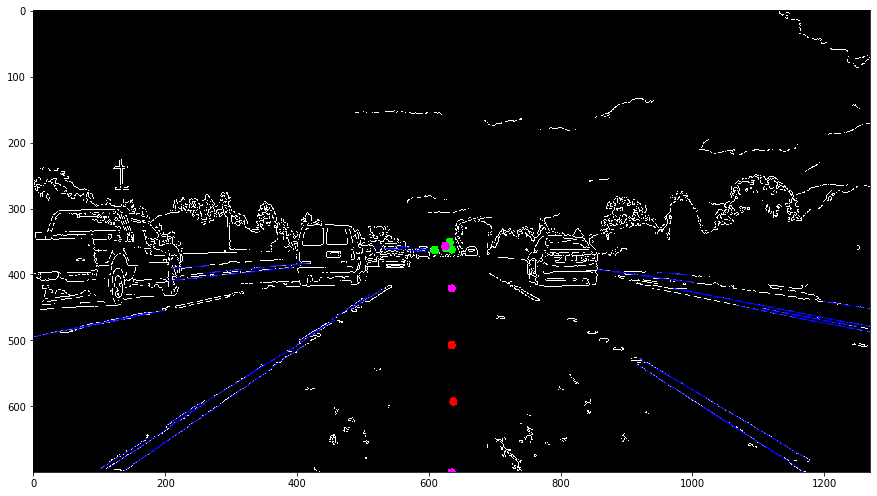

In [19]:
from scipy import interpolate

Nodes=np.array(Nodes)
plt.imshow(img_dsp)
print(Nodes)
'''
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


nodes = np.array( [ [1, 2], [6, 15], [10, 6], [10, 3], [3, 7] ] )

x = nodes[:,0]
y = nodes[:,1]

tck,u     = interpolate.splprep( [x,y] ,s = 0 )
xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

plt.plot( x,y,'o' , xnew ,ynew )
plt.legend( [ 'data' , 'spline'] )
plt.axis( [ x.min() - 1 , x.max() + 1 , y.min() - 1 , y.max() + 2 ] )
plt.show()
'''